In [25]:
# 3class


import argparse
import traceback

import pandas as pd
import numpy as np
from scipy import interpolate

from sklearn import metrics
from sklearn import datasets
from sklearn.model_selection import train_test_split as ts
from sklearn.metrics import roc_curve,auc,roc_auc_score,precision_recall_curve

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.autograd import Variable

from plotnine import *
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device=",device)

black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'



class Config:

    train_dir="m5C/feature/train/"
    test_dir="ELIGOS_C/feature/test/"
    #train_dir = "data/motif/CTCAC/train/"
    #test_dir = "data/motif/CTCAC/test/"
    batch_size = 500
    learning_rate=0.00001
    
    
kmer_encode_dic={'A': 0, "C": 1, "G": 2, "T": 3}   

class BahdanauAttention(nn.Module):
    """
    Bahdanau Attention mechanism module.

    Args:
        in_features (int): Number of input features.
        hidden_units (int): Number of hidden units.
        num_task (int): Number of tasks.
    """
    def __init__(self,in_features, hidden_units,num_task):
        super(BahdanauAttention,self).__init__()
        self.W1 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.W2 = nn.Linear(in_features=in_features,out_features=hidden_units)
        self.V = nn.Linear(in_features=hidden_units, out_features=num_task)

    def forward(self, hidden_states, values):
        hidden_with_time_axis = torch.unsqueeze(hidden_states,dim=1)

        score  = self.V(nn.Tanh()(self.W1(values)+self.W2(hidden_with_time_axis)))
        attention_weights = nn.Softmax(dim=1)(score)
        values = torch.transpose(values,1,2)   # transpose to make it suitable for matrix multiplication
        #print(attention_weights.shape,values.shape)
        context_vector = torch.matmul(values,attention_weights)
        context_vector = torch.transpose(context_vector,1,2)
        return context_vector, attention_weights

class TandemMod(nn.Module):
    def __init__(self,num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5):
        super(TandemMod,self).__init__()

        self.seq_len=seq_len
        self.embed = nn.Embedding(vocab_zie, embedding_size)

        self.cnn_1d = nn.Sequential(
            nn.Conv1d(in_channels=1,out_channels=64,kernel_size=7,stride=2,padding=0),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=0),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),
            nn.Dropout(p=0.2),
            nn.Conv1d(in_channels=128,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2,padding=1),

        )
        self.lstm=nn.LSTM(input_size=128,hidden_size=128,batch_first=True,bidirectional=True)
        self.attention=BahdanauAttention(in_features=256,hidden_units=10,num_task=1)
        self.fc = nn.Sequential(
            nn.Linear(in_features=1536,out_features=1536),
            nn.ReLU(),
            nn.Linear(in_features=1536, out_features=1024),
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512,out_features=3)
        )

        self.lstm_seq=nn.LSTM(input_size=4+5,hidden_size=128,batch_first=True,bidirectional=True)   #embedding_size+feature_num


    def seq_to_digit(self,seq):
        return torch.Tensor([{'A': 0, "C": 1, "G": 2, "T": 3}[i] for i in list(seq)]).long()


    def forward(self,x,kmer,mean,std,intense,dwell,base_quality):
        kmer_embedded=self.embed(kmer)
        mean = torch.reshape(mean, (-1, self.seq_len, 1)).float()
        std = torch.reshape(std, (-1, self.seq_len, 1)).float()
        intense = torch.reshape(intense, (-1, self.seq_len, 1)).float()
        dwell = torch.reshape(dwell, (-1, self.seq_len, 1)).float()
        base_quality = torch.reshape(base_quality, (-1, self.seq_len, 1)).float()
        
        out_seq=torch.cat((kmer_embedded,mean,std,intense,dwell,base_quality),2)


        out_seq,(h_n_seq,c_n_seq)=self.lstm_seq(out_seq)

        x = self.cnn_1d(x)

        batch_size, features, seq_len = x.size()
        x = x.view(batch_size, seq_len, features)  # parepare input for LSTM

        output, (h_n, c_n) = self.lstm(x)

        h_n = h_n.view(batch_size, output.size()[-1])  # pareprae input for Attention
        context_vector, attention_weights = self.attention(h_n, output)  # Attention (batch_size, num_task, unit)


        out=torch.cat((out_seq[:,0,:],out_seq[:,1,:],out_seq[:,2,:],out_seq[:,3,:],out_seq[:,4,:],context_vector[:,0,:]),1)
        #out=context_vector[:,0,:]
        out.view(out.size()[0],1,out.size()[1])
        x=self.fc(out)
        #x.view(x.size()[0], 1, x.size()[1])
        return x


class NN(TandemMod):
    def __init__(self):
        """
        Initialize the NN class.
        Inherits from the TandemMod class.
        """
        super(NN, self).__init__()





class MyDataset(Dataset):
    """
    Custom dataset class.

    Args:
        x (list or numpy array): Input data.
        y (list or numpy array): Target data.

    """
    def __init__(self,x,y):
        self.x=x
        self.y=y

    def __getitem__(self, index):
        return self.x[index],self.y[index]

    def __len__(self):
        return len(self.x)


def make_weights_for_balanced_classes(images, nclasses):
    """
    Computes weights for balancing classes in a dataset.

    Args:
        images (list): List of images.
        nclasses (int): Number of classes.

    Returns:
        list: List of weights.

    """
    count = [0] * nclasses
    for item in images:
        count[item[1]] += 1
    weight_per_class = [0.] * nclasses
    N = float(sum(count))
    for i in range(nclasses):
        weight_per_class[i] = N/float(count[i])
    weight = [0] * len(images)
    for idx, val in enumerate(images):
        weight[idx] = weight_per_class[val[1]]
    return weight


from torch.utils.data import WeightedRandomSampler
class CustomWeightedRandomSampler(WeightedRandomSampler):
    """
    Custom implementation of WeightedRandomSampler.
    WeightedRandomSampler except allows for more than 2^24 samples to be sampled
    Args:
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    """
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def __iter__(self):
        rand_tensor = np.random.choice(range(0, len(self.weights)),
                                       size=self.num_samples,
                                       p=self.weights.numpy() / torch.sum(self.weights).numpy(),
                                       replace=self.replacement)
        rand_tensor = torch.from_numpy(rand_tensor)
        return iter(rand_tensor.tolist())

print("loading data...")

model = TandemMod(num_classes=2,vocab_zie=5, embedding_size=4,seq_len=5).to(device)
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

loss_func = torch.nn.CrossEntropyLoss()#.to(device)
#predict_result=open("rice/results/WT_precit_results.tsv","w")

def predict(model,dataset,cut_off_threshold):
    """
    Predicts the output of the model on the given dataset.

    Parameters:
        model (nn.Module): The trained model to use for prediction.
        dataset (torch.utils.data.Dataset): The dataset to predict on.

    Returns:
        fpr (array): False positive rates.
        tpr (array): True positive rates.
        precision (array): Precision values.
        recall (array): Recall values.
        roc_auc (float): Area under the ROC curve.
        pr_auc (float): Area under the precision-recall curve.
    """

    dataloader=torch.utils.data.DataLoader(dataset=dataset, 
                                           batch_size=4000, 
                                           shuffle=False,
                                           num_workers=36,
                                           pin_memory=True)

    try:

        test_acc = 0.
        y_test = []
        y_pred = []
        label_dict={0:"m5C",1:"C"}
        
        probabilities_all=[]
        labels=[]
        predict_labels=[]
        
        for i,(batch_x, batch_y) in enumerate(dataloader):

            signal, kmer, mean, std, intense, dwell,base_quality = batch_x
            signal= Variable(signal.to(device)).to(torch.float32)

            kmer = Variable(kmer.to(device)).to(torch.long)
            mean = Variable(mean.to(device)).to(torch.float32)
            std = Variable(std.to(device)).to(torch.float32)
            intense = Variable(intense.to(device)).to(torch.float32)
            dwell = Variable(dwell.to(device)).to(torch.float32)
            base_quality = Variable(base_quality.to(device)).to(torch.float32)
            batch_size, features = signal.size()
            signal = signal.view(batch_size, 1, features)

            out = model(signal, kmer, mean, std, intense, dwell,base_quality )
            batch_size, out_channels = out.size()

            out = out.view(batch_size, out_channels)
            pred = torch.max(out, 1)[1].numpy()

            out=torch.softmax(out,dim=1)
            #probabilities=out.detach().numpy()[:,1]
            probabilities=out.detach().numpy()
            batch_y=batch_y.detach().numpy()
            #print(probabilities)
            
            
            selected_batch_y=[]
            selected_probabilities=[]
            selected_pred=[]
            
            for j in range(len(batch_y)):
                if max(probabilities[j,:])>0.33:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
                    selected_pred.append(pred[j])
            print("Probability cutoff:",cut_off_threshold[0],cut_off_threshold[1],"\tPreserved sites:",len(selected_batch_y))
            """
            for j in range(len(batch_y)):
                if probabilities[j]<cut_off_threshold[0] or probabilities[j]>cut_off_threshold[1]:
                    selected_batch_y.append(batch_y[j])
                    selected_probabilities.append(probabilities[j])
                    selected_pred.append(pred[j])
            print("Probability cutoff:",cut_off_threshold[0],cut_off_threshold[1],"\tPreserved sites:",len(selected_batch_y))
            #fpr,tpr,thersholds=roc_curve(selected_batch_y,selected_probabilities)
            #precision,recall,thersholds=precision_recall_curve(selected_batch_y,selected_probabilities)
            """
            #roc_auc=auc(fpr,tpr)
            #pr_auc=auc(recall,precision)
           
            probabilities_all.extend(list(selected_probabilities))
            labels.extend(list(selected_batch_y))
            predict_labels.extend(list(selected_pred))
            #return fpr,tpr,precision,recall,roc_auc,pr_auc,len(selected_batch_y)/len(batch_y),probabilities,batch_y
        return probabilities_all,labels,predict_labels
    except Exception as e:
        print(e)
        traceback.print_exc()
        
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Extract feature from signal.')
    parser.add_argument('-feature', default='BaseCalled_template',help='Basecall subgroup Nanoraw resquiggle into. Default is BaseCalled_template')
    args = parser.parse_args()
  
    
   


device= cpu
loading data...


In [2]:
#read data

x_test_median_mad,y_test_median_mad,site_list=[],[],[]



f=open("/home/wuyou/Projects/paper/m5C/feature/median_mad/unmod.test")
for i,line in enumerate(f):
    if i>=2e3:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])

        #pass
    #if not read_id_dict.get(read_id,0):
    #    continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(0)
    site_list.append(site)
f.close()


#m5C
f=open("/home/wuyou/Projects/paper/m5C/feature/median_mad/mod.test")
for i,line in enumerate(f):
    if i>=2e3:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])

        #pass
    #if not read_id_dict.get(read_id,0):
    #    continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(1)
    site_list.append(site)
f.close()

f=open("/home/wuyou/Projects/ac4c/data/curlcake_ac4C.feature.tsv")
for i,line in enumerate(f):
    if i>=2e3:
        break
    line=line.rstrip()
    items=line.split("\t")
    read_id=line.split("\t")[0]
    site=int(line.split("\t")[2])

        #pass
    #if not read_id_dict.get(read_id,0):
    #    continue

    signals="|".join(items[9:14]).split("|")
    signal=np.array([float(signal) for signal in signals])
    #signal=(signal-np.mean(signal))/np.std(signal)
    kmer = items[3]
    kmer=np.array([kmer_encode_dic[base] for base in kmer])
    mean = np.array([float(item) for item in items[4].split("|")])
    std = np.array([float(item) for item in items[5].split("|")])
    intense = np.array([float(item) for item in items[6].split("|")])
    dwell = np.array([float(item) for item in items[7].split("|")])/200
    base_quality = np.array([float(item) for item in items[8].split("|")])/40
    x=[signal, kmer, mean, std, intense, dwell,base_quality]
    x_test_median_mad.append(x)
    y_test_median_mad.append(2)
    site_list.append(site)
f.close()




In [26]:
dataset=MyDataset(x_test_median_mad,y_test_median_mad)


#model= torch.load('/home/wuyou/Projects/paper/model/m6A_Os_AD_median_mad_length_1000.pkl')
model = torch.load("/data/wuyou/ac4c/model/C_m5C_ac4C_3_class_6.pkl",map_location=torch.device("cpu"))

probabilities,true_labels,predict_labels=predict(model,dataset,[0.5,0.5])

Probability cutoff: 0.5 0.5 	Preserved sites: 4000
Probability cutoff: 0.5 0.5 	Preserved sites: 2000


In [27]:

fprs,tprs,roc_classes,precisions,recalls,pr_classes=[],[],[],[],[],[]


#class 0
probabilities_0=np.array(probabilities)[:,0]
labels_0=[1 if label == 0 else 0 for label in true_labels]

fpr,tpr,thersholds=roc_curve(labels_0,probabilities_0)
precision,recall,thersholds=precision_recall_curve(labels_0,probabilities_0)

roc_auc=auc(fpr,tpr)
pr_auc=auc(recall,precision)

fprs.extend(fpr)
tprs.extend(tpr)
roc_classes.extend(["C %.2f" %roc_auc]*len(fpr))
precisions.extend(precision)
recalls.extend(recall)
pr_classes.extend(["C %.2f" %pr_auc]*len(precision))

#class 1
probabilities_0=np.array(probabilities)[:,1]
labels_0=[1 if label == 1 else 0 for label in true_labels]

fpr,tpr,thersholds=roc_curve(labels_0,probabilities_0)
precision,recall,thersholds=precision_recall_curve(labels_0,probabilities_0)

roc_auc=auc(fpr,tpr)
pr_auc=auc(recall,precision)

fprs.extend(fpr)
tprs.extend(tpr)
roc_classes.extend(["m5C %.2f" %roc_auc]*len(fpr))
precisions.extend(precision)
recalls.extend(recall)
pr_classes.extend(["m5C %.2f" %pr_auc]*len(precision))


#class 2
probabilities_0=np.array(probabilities)[:,2]
labels_0=[1 if label == 2 else 0 for label in true_labels]

fpr,tpr,thersholds=roc_curve(labels_0,probabilities_0)
precision,recall,thersholds=precision_recall_curve(labels_0,probabilities_0)

roc_auc=auc(fpr,tpr)
pr_auc=auc(recall,precision)

fprs.extend(fpr)
tprs.extend(tpr)
roc_classes.extend(["ac4C %.2f" %roc_auc]*len(fpr))
precisions.extend(precision)
recalls.extend(recall)
pr_classes.extend(["ac4C %.2f" %pr_auc]*len(precision))





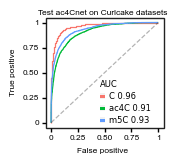

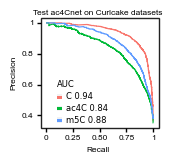

In [28]:
#plot 
from plotnine import *
import pandas as pd


black = '#222222'
gray = '#666666'
red = '#FF3333'
green = '#66CC00'
blue = '#3333FF'
purple = '#9933FF'
orange = '#FF8000'
yellow = '#FFFF33'
c1="#F8766D"
c2="#00BA38" 
c3="#619CFF"

data=pd.DataFrame(dict(fpr=fprs,tpr=tprs,AUC=roc_classes)) 
#data.to_csv("data/ROC_m5C_train_on_curlcake_different_norm_methods.csv")
p1 = (ggplot()
        +geom_line(data,aes(x="fpr",y = "tpr",group="AUC",color="AUC"))
        +geom_line(pd.DataFrame(dict(x=[0,1],y=[0,1])),aes(x="x",y="y"),linetype="dashed",alpha=0.3)
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
            figure_size=[1.52,1.43],
            legend_title = element_text(size=6), #change legend title font size
            legend_text = element_text(size=6),
            legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.65,0.30),
            legend_key_size=4) #change legend text font size
        +labs(x = "False positive", y ="True positive")
        +ggtitle("Test ac4Cnet on Curlcake datasets")
        +guides(color = guide_legend(title = "AUC"))
        +scale_color_manual([c1,c2,c3])
    )
print(p1)
p1.save('figure/validation_ac4Cnet_on_curlcake_3class_ROC.pdf')

data=pd.DataFrame(dict(precision=precisions,recall=recalls,AUC=pr_classes)) 
#data.to_csv("data/PR_m5C_train_on_curlcake_different_norm_methods.csv")
p2 = (ggplot()
        #+geom_line(pd.DataFrame(dict(x=[1,0],y=[0,1])),aes(x="x",y="y"),linetype="dashed")
        +geom_line(data,aes(x="recall",y = "precision",group="AUC",color="AUC"))
        
        +theme(panel_background=element_rect(fill=gray, alpha=0),
            panel_grid_major=element_line(size=0.3, alpha=0,color=black),
            panel_grid_minor=element_line(size=0.3, alpha=0,color=black),
            panel_border=element_rect(color=black, size=1),
            axis_text=element_text(size=6,family="Arial",color="black"),
            axis_title_x=element_text(size=6,family="Arial",color="black"),
            axis_title_y=element_text(size=6,family="Arial",color="black"),
            plot_title=element_text(margin={'b': 1, 'r': 0, 'units': 'pt'},size=6,family="Arial",color="black"),
            figure_size=[1.52,1.43],
            legend_title = element_text(size=6), #change legend title font size
            legend_text = element_text(size=6),
            legend_background=element_rect(size=0.5,alpha=0),
            legend_position=(0.40,0.3),
            legend_key_size=4) #change legend text font size)
        +labs(x = "Recall", y ="Precision")
        +ggtitle("Test ac4Cnet on Curlcake datasets")
        +guides(color = guide_legend(title = "AUC"))
        +scale_color_manual([c1,c2,c3])
        )
print(p2)
p2.save('figure/validation_ac4Cnet_on_curlcake_3class_PR.pdf')
    